In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import math
import wandb
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import cv2
from os import listdir
from os.path import isfile, join
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation

# Priprava dat

- Nacitanie obrazkov z adresaru
- Resizovanie obrazkov na velkost 28x28

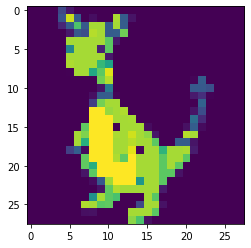

arr.shape
(939, 28, 28)
arr[0].shape
(28, 28)


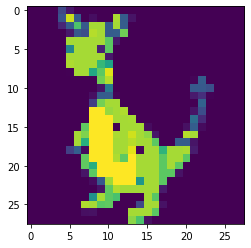

X_train.shape
(60000, 28, 28)
X_train[0].shape
(28, 28)


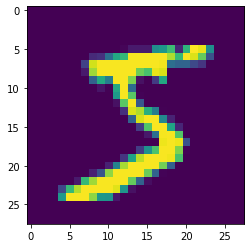

In [2]:
mypath="C:/Users/marti/Documents/GitHub/school-10/NSIETE/1-cviko/3_zadanie/pokemons/kaggle-one-shot-pokemon/pokemon-a/pokemons"
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = np.empty(len(onlyfiles), dtype=object)

for n in range(0, len(onlyfiles)):
    images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
    
gray_images = []
for n in range(0, len(images)):
    x = cv2.cvtColor(images[n], cv2.COLOR_BGR2GRAY)
    x = cv2.resize(x, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    gray_images.append(np.asarray(x))

plt.imshow(gray_images[100])
plt.show()

# for i in range(len(gray_images)):
#     gray_images[i] = np.resize( gray_images[i], (28,28))
    
arr = np.array(gray_images)
print("arr.shape")
print(arr.shape)
    
print("arr[0].shape")
print(arr[0].shape)

plt.imshow(gray_images[100])
plt.show()

(X_train, _), (_, _) = mnist.load_data()
print("X_train.shape")
print(X_train.shape)

print("X_train[0].shape")
print(X_train[0].shape)

plt.imshow(X_train[0])
plt.show()

- Nastavenie velkosti obrazkov

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
dim = 128

- Ukladanie obrazkov

In [4]:
def save_imgs(count, epoch, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"C:/Users/marti/Documents/GitHub/school-10/NSIETE/1-cviko/3_zadanie/generated_images2/mnist_%d_%d.png" % (count, epoch))
    plt.close()

# WandB

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bombinko (use `wandb login --relogin` to force relogin)


True

- Definovanie konfiguracie pre wandb sweepy

In [6]:
# define sweep
sweep_config = {
  "name": "NN-sweep-keras",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'RMSprop']
        },

    'criterion': {
        'values': ['binary_crossentropy']
        },

    'h1': {
        'values': [64,128,256,512]
        },

    'h2': {
        'values': [64,128,256,512]
        },

    'h3': {
        'values': [64,128,256,512]
        },

    'h4': {
        'values': [64,128,256,512]
        },

    'h5': {
        'values': [64,128,256,512]
        },

    'h6': {
        'values': [32,64,128]
        },

    'h7': {
        'values': [32,64,128]
        },

    'h8': {
        'values':[32,64,128]
        },
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        } 
 }

}

- Inicializacia trenovacej funkcie

In [7]:
def train_with_config():
    global sweep_counter
    sweep_counter = sweep_counter + 1
    with wandb.init(config=sweep_config):
    # Specify the other hyperparameters to the configuration
        config = wandb.config
        # Add the config item (layers) to wandb
        if wandb.run:
            optimizer1= build_optimizer(config.optimizer, 0.0001)  
            optimizer2= build_optimizer(config.optimizer, 0.000001)  

            discriminator = build_discriminator(config.h6,config.h7,config.h8)
            discriminator.compile(loss=config.criterion,
                optimizer=optimizer1,
                metrics=['accuracy'])

            generator = build_generator(config.h1,config.h2,config.h3,config.h4,config.h5)
            generator.compile(loss=config.criterion, optimizer=optimizer2)

            z = Input(shape=(dim,))   #Our random input to the generator
            img = generator(z)

            discriminator.trainable = False  

            valid = discriminator(img)  #Validity check on the generated image

            combined = Model(z, valid)
            combined.compile(loss=config.criterion, optimizer=optimizer2)


#             model_train(epochs=100, batch_size=32, save_interval=10)
            batch_size = 32
            epochs=5000
            save_interval=10
            
            X_train = arr
            X_train = np.expand_dims(X_train, axis=3)
            X_train = X_train / 127.5 - 1.
    
            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            for epoch in range(epochs):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                noise = np.random.normal(0, 1, (batch_size, dim))
                gen_imgs = generator.predict(noise)
                d_loss_real = discriminator.train_on_batch(imgs, valid)
                d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                g_loss = combined.train_on_batch(noise, valid)
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                
                wandb.log({'D_loss:': d_loss[0], 'epoch': epoch})
                wandb.log({'acc': 100*d_loss[1], 'epoch': epoch})
                wandb.log({'G_loss': g_loss, 'epoch': epoch})
                       
                if epoch % save_interval == 0:
                    save_imgs(sweep_counter, epoch, generator)

#             generator.save('generator_model.h5')  

- Inicializacia optimizerov

In [ ]:
# def build_optimizer(optimizer, learning_rate):
    if optimizer == "Adam":
        optimizer = Adam(learning_rate, 0.5)
    elif optimizer == "RMSprop":
        optimizer = RMSprop(learning_rate, 0.5)
    return optimizer

- Inicializacia generatora

In [9]:
def build_generator(h1,h2,h3,h4,h5):
    noise_shape = (dim,)   
    model = Sequential() 
    model.add(Dense(dim * 7 * 7, activation="relu", input_dim=dim))
    model.add(Reshape((7, 7, dim)))
    model.add(Conv2DTranspose(h1, kernel_size=4, strides=(1, 1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Conv2DTranspose(h2, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Conv2DTranspose(h3, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))    
#     model.add(Conv2DTranspose(h4, kernel_size=4, strides=1, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2DTranspose(h5, kernel_size=4, strides=1, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("sigmoid"))    
    model.summary()
    noise = Input(shape=noise_shape)
    img = model(noise)    
    return Model(noise, img)

- Inicializacia discriminatora

In [10]:
def build_discriminator(h1, h2, h3):    
    model = Sequential()
    model.add(Conv2D(h1, kernel_size=4, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(h2, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(h3, kernel_size=4, strides=2, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))    
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

- Pocitadlo sweepov - sluzi na rozdelenie vygenerovanych obrazkov na sweepy

In [11]:
sweep_counter = 20

- Inicializacia wandb sweepu

In [12]:
sweep_id = wandb.sweep(sweep_config) 

Create sweep with ID: alkypxvk
Sweep URL: https://wandb.ai/bombinko/uncategorized/sweeps/alkypxvk


- Spustenie sweepu

In [ ]:
wandb.agent(sweep_id, function=train_with_config, count=5)

wandb: Agent Starting Run: y0gdf8g5 with config:
wandb: 	criterion: binary_crossentropy
wandb: 	h1: 512
wandb: 	h2: 512
wandb: 	h3: 128
wandb: 	h4: 512
wandb: 	h5: 64
wandb: 	h6: 128
wandb: 	h7: 64
wandb: 	h8: 128
wandb: 	learning_rate: 0.08090158264628283
wandb: 	optimizer: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       2176      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          131136    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3